# “Go not to the Elves for counsel, for they will say both no and yes.”
-- Frodo Baggins

# Outline

- Brief Pat101

- Introduction to/Context of the problem

- Approach (merits, justification)

- Methods/Code

- Model and its Performance

- Conclusions

![pat101](pat101slide_july2022.PNG)

## THE PROBLEM

# SMILES -> L1

Objective: Predict the L1 classification (e.g. 'Enzyme','Transcription Factor','Membrane protein/receptor') of the *protein* (not plural!) that a ligand may bind to, given the ligand's SMILES code.

ASSUMPTION: Each ligand binds to only one protein. ("SMILES can bind with multiple categories of proteins, but it is rare.")

# Context of the Problem

Ligand Screening, which may be done for many reasons:

- Reduce number of experiments and examine a *MUCH* larger chemical space

- Identify optimal ligands, i.e., the best N therapeutic candidates 

- Study the commonalities of ligands that do bind; e.g. functional groups

Not possible here given the assumption, but with a few modifications:

- Look for x-specific (e.g. bispecific) ligands

- Identify potential off-target effects, likelihood of side-effects... (with identified optimal ligands, see predicted probability of binding to other classes/proteins)

## THE APPROACH

Given 1,000,000+ SMILES Codes and the *VERY* broad L1 Category (15 classes) ...

Chemical Approach:

- Generate/predict a bunch of chemical features (binding energy possible but not likely valuable in this study)

- Identify useful features from past work: see DeepTox

- Comptuationally intensive - use subset of data during development

- Use ML classification algorithms to predict the SINGLE targets of ea. ligand

Pros: 

- Can analyze specific chemical features in post-analysis

- Reasonably modular/scalable; can add more predicted chemical features, docking results, *and assay results if they exist*

Cons:

- Limited structural information, e.g. 'fingerprint'

- Computationally intensive, at least w. RDKIT and one EC2 instance; w. docking etc. much more intensive

- No assays, all data in-silico

Alternative Structural Approach (EXTREMELY NAIVE):

- One-Hot Encode (i.e. 1/0 if character is A, B, or C) the SMILES codes, as strings

- Predict class using convolutional neural network 

- Based on work that followed up on DeepTox; identified interesting common structural features

Pros:

- Identifies relevant, common structures that *ARE* SMILES codes and can be directly re-input to screen for ligands with that feature

- Easier to implement

Cons:

- ONLY structural data generated; no further analysis can be done, no other features to analyze

Therefore more of a supplementary model to confirm hits or dig into exact structures of interest.

Citations:

DeepTox:

https://www.frontiersin.org/articles/10.3389/fenvs.2015.00080/full
Mayr, Andreas, et al. "DeepTox: toxicity prediction using deep learning." Frontiers in Environmental Science 3 (2016): 80.

CNN/One-Hot:

https://link.springer.com/article/10.1186/s12859-018-2523-5
Hirohara, Maya, et al. "Convolutional neural network based on SMILES representation of compounds for detecting chemical motif." BMC bioinformatics 19.19 (2018): 83-94.

## Method/Codes

In [3]:
# coding: utf-8
from sklearn import metrics
from sklearn.naive_bayes import GaussianNB
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import accuracy_score
import pandas as pd
import sys as sys
import os as os
import ast as ast
from rdkit import Chem
from rdkit.Chem.SaltRemover import SaltRemover
from rdkit.Chem import PandasTools
from rdkit import RDConfig
from rdkit.Chem import PandasTools as pdt
from rdkit.Chem import Descriptors as D
from xgboost import XGBClassifier
import xgboost as xgb
import numpy as np

# Data loading...

In [4]:

# smiles_l1.csv should be in the same directory as the .ipynb

big_df = pd.read_csv("smiles_l1.csv")  # warning: BIG file

# 1 million (Dr.Evil face) samples! let's get 1%; gives 16 classes including 'unknown'
df = big_df.sample(frac=0.01, replace=False, random_state=11)

# alternative if desired to train the model on EVERYTHING:
# df = big_df

df.dropna() #paranoia

# get those lists in the 2nd column resolved; unknown to me still if they're just dup'd
# using ast.literal_eval enables import as a list w one element rather than an entire list
df.L1_class_name = df.L1_class_name.apply(ast.literal_eval)


In [5]:
df.head()

,canonical_smiles,L1_class_name
1160872,Nc1[nH]c(C(=O)c2ccccc2)c(-c2ccccc2C(F)(F)F)c1C...,[Enzyme]
347949,CCOC(=O)C(=O)Nc1cc(C)c(Oc2ccc(O)c(C(C)C)c2)c(C)c1,[Transcription factor]
585208,COCCn1c(=O)nc(Nc2ccc(OC(C)C)c(F)c2)n(Cc2ccc(Cl...,[Ion channel]
1018911,Cc1nc2sc(C(=O)NC3CCOC3)c(N)c2c(C)c1Cl,[Membrane receptor]
1276212,O=C(Nc1ccc(Oc2ccnc(NC(=O)C3CC3)c2)nc1)Nc1ccc(C...,[Enzyme]


In [5]:

df.describe()

,canonical_smiles,L1_class_name
count,14379,14379
unique,14379,16
top,Nc1[nH]c(C(=O)c2ccccc2)c(-c2ccccc2C(F)(F)F)c1C...,[Enzyme]
freq,1,6967


# Process L1 Class data...

In [8]:
df['string_L1'] = df['L1_class_name'].apply(lambda x: x[0])
df.head()
# so this lambda fn; we set x = the first and only element in L1_class_name; that
# x becomes string_L1 in our new column. 

# pd DEMANDS you declare your factors and get the KEY of what they are
df['Target_Class'], uniques = pd.factorize(df.string_L1)
df.head()

,canonical_smiles,L1_class_name,string_L1,Target_Class
1160872,Nc1[nH]c(C(=O)c2ccccc2)c(-c2ccccc2C(F)(F)F)c1C...,[Enzyme],Enzyme,0
347949,CCOC(=O)C(=O)Nc1cc(C)c(Oc2ccc(O)c(C(C)C)c2)c(C)c1,[Transcription factor],Transcription factor,1
585208,COCCn1c(=O)nc(Nc2ccc(OC(C)C)c(F)c2)n(Cc2ccc(Cl...,[Ion channel],Ion channel,2
1018911,Cc1nc2sc(C(=O)NC3CCOC3)c(N)c2c(C)c1Cl,[Membrane receptor],Membrane receptor,3
1276212,O=C(Nc1ccc(Oc2ccnc(NC(=O)C3CC3)c2)nc1)Nc1ccc(C...,[Enzyme],Enzyme,0


In [13]:
uniques

Index(['Enzyme', 'Transcription factor', 'Ion channel', 'Membrane receptor',
       'Epigenetic regulator', 'Transporter', 'Structural protein',
       'Secreted protein', 'Other cytosolic protein', 'Unclassified protein',
       'Auxiliary transport protein', 'Other membrane protein',
       'Surface antigen', 'Other nuclear protein', 'Adhesion'],
      dtype='object')

# RDKit Molecules and Descriptors...

,canonical_smiles,L1_class_name,ROMol
1160872,Nc1[nH]c(C(=O)c2ccccc2)c(-c2ccccc2C(F)(F)F)c1C...,[Enzyme],
347949,CCOC(=O)C(=O)Nc1cc(C)c(Oc2ccc(O)c(C(C)C)c2)c(C)c1,[Transcription factor],
585208,COCCn1c(=O)nc(Nc2ccc(OC(C)C)c(F)c2)n(Cc2ccc(Cl...,[Ion channel],
1018911,Cc1nc2sc(C(=O)NC3CCOC3)c(N)c2c(C)c1Cl,[Membrane receptor],
1276212,O=C(Nc1ccc(Oc2ccnc(NC(=O)C3CC3)c2)nc1)Nc1ccc(C...,[Enzyme],

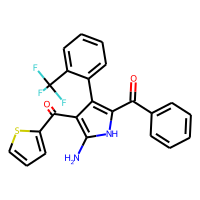
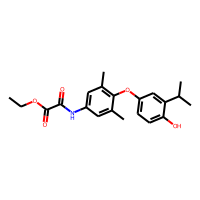
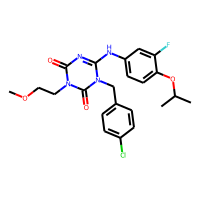
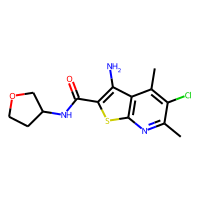
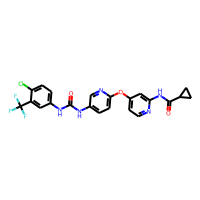

In [6]:
# takes ~ 26 seconds with 1% of data and t3.xlarge
pdt.AddMoleculeColumnToFrame(df, 'canonical_smiles', includeFingerprints=True)
df.head()

# Salt processing...

Salts are relevant here, but there were several molecules that only differed by number of salts; don't wanna bias the data with duplicates so:

In [16]:
# It contains all the salts that I could find (searching through the .csv for .[] etc.) in this dataset
remover = SaltRemover(defnData="[Cl,Br,Zn,Mg,Ca,Sr,Na,K]")

# in this case we don't add a new column, just apply a function to the molecules
df['ROMol'].apply(lambda x: remover.StripMol(x))

df['Cleaned_SMILES'] = df['ROMol'].apply(lambda x: Chem.MolToSmiles(x))


,canonical_smiles,L1_class_name,string_L1,Target_Class,ROMol,Cleaned_SMILES
1160872,Nc1[nH]c(C(=O)c2ccccc2)c(-c2ccccc2C(F)(F)F)c1C...,[Enzyme],Enzyme,0,"<img data-content=""rdkit/molecule"" src="""" alt=""Mol""/>",Nc1[nH]c(C(=O)c2ccccc2)c(-c2ccccc2C(F)(F)F)c1C...
347949,CCOC(=O)C(=O)Nc1cc(C)c(Oc2ccc(O)c(C(C)C)c2)c(C)c1,[Transcription factor],Transcription factor,1,"<img data-content=""rdkit/molecule"" src="""" alt=""Mol""/>",CCOC(=O)C(=O)Nc1cc(C)c(Oc2ccc(O)c(C(C)C)c2)c(C)c1
585208,COCCn1c(=O)nc(Nc2ccc(OC(C)C)c(F)c2)n(Cc2ccc(Cl...,[Ion channel],Ion channel,2,"<img data-content=""rdkit/molecule"" src="""" alt=""Mol""/>",COCCn1c(=O)nc(Nc2ccc(OC(C)C)c(F)c2)n(Cc2ccc(Cl...
1018911,Cc1nc2sc(C(=O)NC3CCOC3)c(N)c2c(C)c1Cl,[Membrane receptor],Membrane receptor,3,"<img data-content=""rdkit/molecule"" src="""" alt=""Mol""/>",Cc1nc2sc(C(=O)NC3CCOC3)c(N)c2c(C)c1Cl
1276212,O=C(Nc1ccc(Oc2ccnc(NC(=O)C3CC3)c2)nc1)Nc1ccc(C...,[Enzyme],Enzyme,0,"<img data-content=""rdkit/molecule"" src="""" alt=""Mol""/>",O=C(Nc1ccc(Oc2ccnc(NC(=O)C3CC3)c2)nc1)Nc1ccc(C...

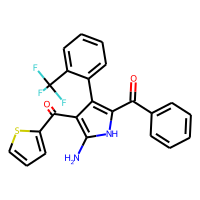
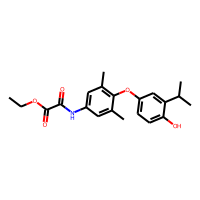
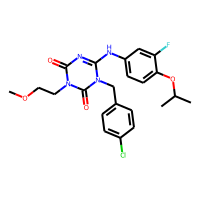
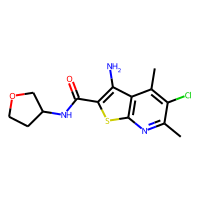
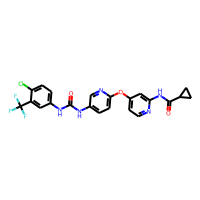

In [17]:
df.head()

In [18]:
# we're gonna get rid of duplicates, let's see original sample #s:
df.describe()

,Target_Class
count,14379.000000
mean,2.233465
std,2.907931
min,0.000000
25%,0.000000
50%,1.000000
75%,3.000000
max,14.000000


In [19]:
# now drop duplicate mols based on cleaned up smiles

# Drop the duplicate mols, keep only the first one; big danger
# that some of the salts may matter... but one of those samples had like
# 20 salts and that's real sus to me
df = df.drop_duplicates(subset='Cleaned_SMILES',keep='first') 
df.describe()

# welp, in this sample we all gucci. w. settings:
# df = big_df.sample(frac=0.01, replace=False, random_state=11)

,Target_Class
count,14379.000000
mean,2.233465
std,2.907931
min,0.000000
25%,0.000000
50%,1.000000
75%,3.000000
max,14.000000


# Feature Generation (finally)

In [20]:
# takes ~30 seconds, 1% data, t3.xlarge

# topological polar surface area for the molecule; 
# poking around the data it seemed there were a number
# of polar phosphate-salt groups, so the S and P option is used
# ... without noticeable effect on end results vs. not including S and P, I'll add
df['TPSA'] = df['ROMol'].apply(lambda x: D.TPSA(x, includeSandP = True))

# the rest I think require less explanation:
df['MolLogP'] = df['ROMol'].apply(lambda x: D.MolLogP(x))
df['MolWt'] = df['ROMol'].apply(lambda x: D.MolWt(x))
df['MaxPartialCharge'] = df['ROMol'].apply(lambda x: D.MaxPartialCharge(x))
df['MinPartialCharge'] = df['ROMol'].apply(lambda x: D.MinPartialCharge(x))
df['HeavyAtomMolWt'] = df['ROMol'].apply(lambda x: D.HeavyAtomMolWt(x))
df['NumRadicalElectrons'] = df['ROMol'].apply(
    lambda x: D.NumRadicalElectrons(x))
df['NumValenceElectrons'] = df['ROMol'].apply(
    lambda x: D.NumValenceElectrons(x))
df['NumHAcceptors'] = df['ROMol'].apply(lambda x: D.NumHAcceptors(x))
df['NumHDonors'] = df['ROMol'].apply(lambda x: D.NumHDonors(x))
df['NumAromaticRings'] = df['ROMol'].apply(lambda x: D.NumAromaticRings(x))

# ... except for these, which I thought could be interesting;
# Morgan fingerprint, at least my perception, is somewhat analagous to ECFP:
# https://pubs.acs.org/doi/10.1021/ci100050t
# Rogers, David, and Mathew Hahn. "Extended-connectivity fingerprints." Journal of chemical information and modeling 50.5 (2010): 742-754.
# this exact implementation here in RDKit is... honestly not too clearly documented
# but I thought it'd be interesting to include; the visual implementation is more informative than this number I think

df['FpDensityMorgan1'] = df['ROMol'].apply(lambda x: D.FpDensityMorgan1(x))
df['FpDensityMorgan2'] = df['ROMol'].apply(lambda x: D.FpDensityMorgan2(x))
df['FpDensityMorgan3'] = df['ROMol'].apply(lambda x: D.FpDensityMorgan3(x))

# OG paper:
# https://pubs.acs.org/doi/pdf/10.1021/c160017a018
# 1965!! 
# Morgan, Harry L. "The generation of a unique machine description for chemical structures-a technique developed at chemical abstracts service." Journal of chemical documentation 5.2 (1965): 107-113.

# more LOTR:
# Capecchi, Alice, Daniel Probst, and Jean-Louis Reymond. 
# "One molecular fingerprint to rule them all: drugs, biomolecules, and the metabolome." Journal of cheminformatics 12.1 (2020): 1-15.

# Move Y to the end...

And see data types, sanity check

In [21]:
# I'm more familiar with data wrangling in R so,
# credit to Charlie Haley from this stackoverflow, this operation IMO is easier in R:
# https://stackoverflow.com/questions/35321812/move-column-in-pandas-dataframe
# Charlie Haley's answer 

colNames = df.columns.values
colNames = list(df.columns.values)
colNames.pop(colNames.index('Target_Class'))
df = df[colNames + ['Target_Class']]

# this manipulation though is potentially the source of some error I was having in the next step, so out of paranoia:
df.dropna()
df.dtypes

canonical_smiles        object
L1_class_name           object
string_L1               object
ROMol                   object
Cleaned_SMILES          object
TPSA                   float64
MolLogP                float64
MolWt                  float64
MaxPartialCharge       float64
MinPartialCharge       float64
HeavyAtomMolWt         float64
NumRadicalElectrons      int64
NumValenceElectrons      int64
NumHAcceptors            int64
NumHDonors               int64
NumAromaticRings         int64
FpDensityMorgan1       float64
FpDensityMorgan2       float64
FpDensityMorgan3       float64
Target_Class             int64
dtype: object

Apologies that the ROMol column is pretty gnarly, if you scroll far enough the Y, Target_Class is there.

Now to finally separate out train and test samples. 

(WARNING: I'm pretty sure it's this next operation rather than the above column manipualtion that generates some errors in a basic Naive-Bayes model; not sure what it is about scikit but I'm pretty sure XGBoost fixes itself and otherwise I had to do some weird operation to resolve some NA errors generated by NA's that don't exist up until this point. I include this explanation and note the code below in case during the reproduction of this code a similar error occurs.)

# Split the data:

In [22]:
x_train, x_test, y_train, y_test = train_test_split(df[['TPSA', 'MolLogP', 'MolWt', 'MaxPartialCharge', 'MinPartialCharge', 'HeavyAtomMolWt', 'NumRadicalElectrons', 'NumValenceElectrons',
                                                    'NumHAcceptors', 'NumHDonors', 'NumAromaticRings', 'FpDensityMorgan1', 'FpDensityMorgan2', 'FpDensityMorgan3']], df.Target_Class, test_size=0.2, random_state=1)


Note random state = 1 is specified above, so I can discuss the results with confidence they're the same... although getting different data (from sampling df from big_df above) didn't seem to make much difference anyway.

Now, scale/normalize our data:

# Normalize data:

In [26]:
sc = StandardScaler() # from sci-kit, for the sake of documenting paranoia
x_train = sc.fit_transform(x_train)
x_test = sc.transform(x_test)

I favor XGBoost for multiclassification problems; I did some hyperparameter tuning off-screen to... no noticeable difference, so, mostly/all defaults:

# Parameter definition/setup:

In [28]:
df.Target_Class.describe() 
# max of 14, i.e. 0 - > 14 therefore 15 classes

count    14379.000000
mean         2.233465
std          2.907931
min          0.000000
25%          0.000000
50%          1.000000
75%          3.000000
max         14.000000
Name: Target_Class, dtype: float64

In [34]:
x_train_xg = xgb.DMatrix(x_train, label=y_train)
x_test_xg = xgb.DMatrix(x_test,  label=y_test)
x_train_xg = xgb.DMatrix(x_train, label=y_train)
x_test_xg = xgb.DMatrix(x_test,  label=y_test)

# initialize params for xgboost
params = {} 
# i've seen and i'm pretty sure done implementation with this stuff in here,
# but weird errors in VSCode

# for classification, using softmax (as would be done in pytorch)
params['objective'] = 'multi:softmax'
params['num_class'] = 15 # 0 - 14 indeces for the L1 classes
params['eta'] = 0.3  # DEFAULT 0.3; aka learning_rate
params['max_depth'] = 6  # DEFAULT 6
params['scale_pos_weight'] = 100 # default 1 so let's see , # i think??
epochs = 5  # seems to work best, 1000 didn't improve accuracy 

# to see evolution of the model:
watchlist = [(x_train_xg, 'train'), (x_test_xg, 'test')]

# FIXME!! add code for grid search. ideally extensible to pytorch etc.

And now for our model!!...

# MODELING!

In [35]:
# THE MAGIC!!!!!!
model = xgb.train(params, x_train_xg, epochs, watchlist)

# get prediction
pred = model.predict(x_test_xg)

# get performance (based on xgboost github)
error_rate = np.sum(pred != y_test) / y_test.shape[0]
print('Overall error using softmax = {}'.format(error_rate))

[06:24:17] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1645117766796/work/src/learner.cc:576: 
Parameters: { "scale_pos_weight" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[06:24:18] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1645117766796/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softmax' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[0]	train-mlogloss:2.13765	test-mlogloss:2.20805
[1]	train-mlogloss:1.93357	test-mlogloss:2.03873
[2]	train-mlogloss:1.79809	test-mlogloss:1.93606
[3]	train-mlogloss:1.69747	test-mlogloss:1.86227
[4]	train-mlogloss:1.61961	test-mloglos

Oh. Well, let's take a look at the exact numbers (the classes are still numbered per pandas factorize; below I'll print the key which aligns with 0-14... based on performance I don't think I'll look at how to make it pretty)

# XGBoost Performance

In [36]:
print('XGB Classification Report...')
print(classification_report(y_test,pred))
print(uniques) # this is the key

XGB Classification Report...
              precision    recall  f1-score   support

           0       0.49      0.95      0.65      1326
           1       0.59      0.06      0.10       178
           2       0.43      0.02      0.05       123
           3       0.42      0.21      0.28       503
           4       1.00      0.00      0.01       259
           5       0.33      0.02      0.04        92
           6       0.00      0.00      0.00        90
           7       0.00      0.00      0.00        17
           8       0.00      0.00      0.00        69
           9       0.73      0.04      0.08       197
          10       0.00      0.00      0.00         2
          11       0.00      0.00      0.00        11
          12       0.00      0.00      0.00         1
          13       0.00      0.00      0.00         3
          14       0.00      0.00      0.00         5

    accuracy                           0.48      2876
   macro avg       0.27      0.09      0.08      28

/home/ubuntu/miniconda3/envs/vina/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ubuntu/miniconda3/envs/vina/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ubuntu/miniconda3/envs/vina/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result)

"I'm not angry, just disappointed." Is how I'd describe how I feel about those results. To discuss a little:
'support' details the number of samples of that class, e.g. there were 1326 actual enzyme samples that were fed into the model; of those predictions to be enzymes, half of the predictions were correct; 90% of the enzyme predictions that did occur were good; but, looking at the rest of the data, one can surmise that the model was overfitted to enzymes; they are the vast majority of this sample of the dataset, so it checks out.

I also test a Naive Bayes below, which actually performs even worse; this shows XG is doing better here, but it may be due to overfitting. Either way, not a success; but I'm getting ahead of myself.

# Try with Naive-Bayes

In [37]:

# the sklearn split method is somehow introducing problems

x_train = np.nan_to_num(x_train)
y_train = np.nan_to_num(y_train)
x_test = np.nan_to_num(x_test)
y_test = np.nan_to_num(y_test)

# VERY STRANGE! BUT PREVENTS BELOW FROM EXPERIENCING HORRIBLE ERRORS

modelGNB = GaussianNB()
modelGNB.fit(x_train, y_train)

gnb_pred = modelGNB.predict(x_test)
print("GNB overall accuracy:")
print(metrics.accuracy_score(y_test, gnb_pred))
print("GNB Classification Report...")
print(classification_report(y_test,gnb_pred))

GNB overall accuracy:
0.28372739916550765
GNB Classification Report...
              precision    recall  f1-score   support

           0       0.49      0.47      0.48      1326
           1       0.20      0.01      0.02       178
           2       0.00      0.00      0.00       123
           3       0.24      0.03      0.06       503
           4       0.13      0.64      0.21       259
           5       0.08      0.03      0.05        92
           6       0.00      0.00      0.00        90
           7       0.00      0.00      0.00        17
           8       0.00      0.00      0.00        69
           9       0.00      0.00      0.00       197
          10       0.00      0.00      0.00         2
          11       0.01      0.09      0.03        11
          12       0.00      0.00      0.00         1
          13       0.00      0.00      0.00         3
          14       0.11      0.20      0.14         5

    accuracy                           0.28      2876
   macro 

/home/ubuntu/miniconda3/envs/vina/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ubuntu/miniconda3/envs/vina/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ubuntu/miniconda3/envs/vina/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result)

The GNB model seems to be less fit to the enzymes, performs worse and perhaps gives a better idea of how well these two models are performing.

--------


A very lackluster outcome, but not unexpected. 'Enzymes' alone describes a plethora of proteins. I've been working with hemoproteins for a bit, and the entire class mostly binds heme-b and heme-c, with one type of hemoprotein ONLY binding siroheme. The specificity of many proteins is amazing, and consequently I'm not surprised it's so difficult and here at least, fruitless to try and predict if a ligand will interact preferentially with a whole category of proteins.

This is speaking for only 1% of the entire dataset provided; I've worked with 1% in this notebook, but when running different tests, going up to 5 or 10% took MUCH longer to run, and at least with this configuration, didn't really improve performance of the models. 

Given some more time (I say, bashfully, perhaps prior to a presentation) I'd likely run the whole dataset to quantify any improvement. I suspect the best way to improve from here would be to take equivalent sample sizes of each L1 category and feed that into the models to avoid overfitting for one category. After evaluating that performance I'd look at the distributions of different predicted properties per L1 category. 


... So, if one wants to negate all that I've just discussed, go above to 'QQQQ' and comment as needed, will train the model on everything.

-------

I'll end by providing a cell below to process holdout data and call the XGB model above, and output similar metrics. Change the CSV name and then scroll down to output; I was a little lazy but this should generate all the requisite data as above and then feed in for predictions.

Thanks for your time and consideration.